# Вебинар 5. Ранжирование и Гибридные рекоммендательные системы

# 1. Ранжирование

### 1.1 BPR - Bayesian Personalized Ranking loss

$$loss = \sigma(p^{+} - p^{-})$$

1. Случайная пара user - купленный им item_i = позитивная пара
2. Для того же юзера сэмплируем item_j (не купил или вес в user-item матрице ниже, у item_i из 1.) - негативная пара
3. Прогнозы модели $p^{+}$, $p^{-}$ --> $p^{+} - p^{-}$
4. loss = $\sigma(p^{+} - p^{-})$ - это и есть наша ошибка
5. Обновляем эмбеддинги

### 1.2 WARP = Weighted Approximate-Rank Pairwise loss
Неплохое [объяснение](https://medium.com/@gabrieltseng/intro-to-warp-loss-automatic-differentiation-and-pytorch-b6aa5083187a) на игрушечном примере

$$loss = ln(\frac{K-1}{N})*(p^- - p^+)$$

1. Сэмплируем случайную позитивную пару юзер-item, прогноз модели для этой пары $p^+$
2. Сюмплируем далее до тех пор, пока не найдем негативную пару, где прогнозная вероятность $p^-$ > $p^+$
3. K - общее количество рекомендаций
4. N - кол-во сэмплирований (зависит от качества модели!)

**Note**  
loss зависит только от 2-ух сэмплированных пар, эмбеддинги только для этих пар будут обновлены

In [ ]:
# Case 1
p_plus = 4.3  # true = 1
p_neg_1 = -2.3 
p_neg_2 = 4.5

loss(random_seed) = [(3-1) / 10 * (4.5 - 4.3)]

# Case 2 -  модель лучше в этом случае
p_plus = 4.3  # true = 1
p_neg_1 = -2.3 
p_neg_2 = 0.5
p_neg_3 = -0.5
p_neg_4 = 2.1
p_neg_5 = 4.5

loss(random_seed) = [(6-1) / 10 * (4.5 - 4.3)]

### Зачем нужно ранжирование? Есть же классификация (предсказание 0 и 1)
- Ранжирование гораздо лучше выбирает топ-k товаров, особенно когда k велико
- Ранжирование позволяет напрямую ранжировать 5 релевантных юзеру товаров (какой из 5 поставить выше?)

---

# 2. LightFM

Формула эмбеддинга в ALS (матричной факторизации)

$$user_{emb} = \theta_1 * i_1 + ... + \theta_n * i_n$$  
  
$$p = user_{emb} * item_{emb}^T + b_u + b_i$$

Формула в LightFM

$$user_{emb} = \theta_1 * i_1 + ... + \theta_n * i_n + \alpha_1 * f_1 + ... + \alpha_k * f_k$$  
  
$$p = user_{emb} * item_{emb}^T + b_u + b_i$$

### Зачем нужны гибридные системы?

*Холодный старт* - ситуация, в которой с товаром/юзером в матрице мало взаимодействий

Холодный старт для товаров - обычно введение нового товара (YouTube, Lamoda, hh.ru)  
Холодный старт для юзера - к нам пришел новый юзер  

Холодного юзера/товар можно описать фичами --> мы больше о нем знаем --> он уже не такой холодный

In [ ]:
# !pip install lightfm

In [ ]:
# !pip install implicit

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

from lightfm import LightFM

# Функции из 1-ого вебинара
import os, sys

module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

In [ ]:
!ls /content/drive/MyDrive/Colab Notebooks/Рекомендательные системы/metrics.py
!cat '/content/drive/MyDrive/Colab Notebooks/Рекомендательные системы/metrics.py'
!cat '/content/drive/MyDrive/Colab Notebooks/Рекомендательные системы/utils.py'
!cat '/content/drive/MyDrive/Colab Notebooks/Рекомендательные системы/recommenders.py'

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/Рекомендательные системы/')

import metrics
from utils import prefilter_items
from recommenders import MainRecommender

In [92]:
from lightfm.evaluation import precision_at_k, recall_at_k

from metrics import precision_at_k as custom_precision, recall_at_k
# from utils import prefilter_items

In [93]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Рекомендательные системы/retail_train.csv')

item_features = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Рекомендательные системы/product.csv')
user_features = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Рекомендательные системы/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)

# train test split
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [94]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [95]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [96]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [97]:
user_features['age_desc'].unique()

array(['65+', '45-54', '25-34', '35-44', '19-24', '55-64'], dtype=object)

In [98]:
user_features['marital_status_code'].unique()

array(['A', 'U', 'B'], dtype=object)

In [99]:
user_features['household_size_desc'].unique()

array(['2', '3', '4', '1', '5+'], dtype=object)

## 1. Filter items

In [100]:
data_train.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [101]:
n_items_before = data_train['item_id'].nunique()

data_train_filtered = prefilter_items(data_train, take_n_popular=5000, item_features=item_features)

n_items_after = data_train_filtered['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

/content/drive/MyDrive/Colab Notebooks/Рекомендательные системы/utils.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price'] = data['sales_value'] / (np.maximum(data['quantity'], 1))


Decreased # items from 86865 to 5001


# 2. Prepare data set

## 2.1 Prepare csr train matrix

In [102]:

user_item_matrix = pd.pivot_table(data_train_filtered, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробовать другие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат sparse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(2)

item_id,117847,818981,819255,819308,819400,819487,819590,819594,819840,819845,...,15926775,15926844,15926886,15972074,15972298,15972565,15972790,16100266,16729299,16729415
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2.2 Prepare CSR test matrix

In [103]:
data_test = data_test[data_test['item_id'].isin(data_train['item_id'].unique())]

test_user_item_matrix = pd.pivot_table(data_test, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробоват ьдругие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

test_user_item_matrix = test_user_item_matrix.astype(float) # необходимый тип матрицы для implicit

In [104]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

## 3. Prepare user and item features

In [105]:
user_feat = pd.DataFrame(user_item_matrix.index)
user_feat = user_feat.merge(user_features, on='user_id', how='left')
user_feat.set_index('user_id', inplace=True)
user_feat.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
user_id,,,,,,,
1,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [106]:
user_feat.shape

(2497, 7)

In [107]:
item_feat = pd.DataFrame(user_item_matrix.columns)
item_feat = item_feat.merge(item_features, on='item_id', how='left')
item_feat.set_index('item_id', inplace=True)

item_feat.head(2)

,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
item_id,,,,,,
117847,450.0,NUTRITION,National,REFRIGERATED,SOY/RICE MILK,64 OZ
818981,194.0,GROCERY,National,COLD CEREAL,ALL FAMILY CEREAL,10.4 OZ


In [108]:
item_feat.shape

(5001, 6)

## Encoding features

In [109]:
user_feat_lightfm = pd.get_dummies(user_feat, columns=user_feat.columns.tolist())
item_feat_lightfm = pd.get_dummies(item_feat, columns=item_feat.columns.tolist())

In [110]:
user_feat_lightfm.head(2)

,age_desc_19-24,age_desc_25-34,age_desc_35-44,age_desc_45-54,age_desc_55-64,age_desc_65+,marital_status_code_A,marital_status_code_B,marital_status_code_U,income_desc_100-124K,...,hh_comp_desc_Unknown,household_size_desc_1,household_size_desc_2,household_size_desc_3,household_size_desc_4,household_size_desc_5+,kid_category_desc_1,kid_category_desc_2,kid_category_desc_3+,kid_category_desc_None/Unknown
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,1,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Init model

In [111]:
model = LightFM(no_components=40,
                loss='bpr', # "logistic","bpr", "warp"
                learning_rate=0.01, 
                item_alpha=0.4,
                user_alpha=0.1, # коэф регуляризации
                random_state=42,
                k=5,
                n=15,
                max_sampled=100)

## Train

In [112]:
model.fit((sparse_user_item > 0) * 1,  # user-item matrix из 0 и 1
          sample_weight=coo_matrix(user_item_matrix),
          user_features=csr_matrix(user_feat_lightfm.values).tocsr(), # делает модель гибридной
          item_features=csr_matrix(item_feat_lightfm.values).tocsr(), # делает модель гибридной
          epochs=20, 
          num_threads=20,
          verbose=True) 

Epoch: 100%|██████████| 20/20 [00:41<00:00,  2.09s/it]


# Getting embeddings

## вектора по пользователям

In [113]:
user_emb = model.get_user_representations(features=csr_matrix(user_feat_lightfm.values).tocsr())

In [114]:
user_emb[0].shape # biases

(2497,)

In [115]:
user_emb[1].shape # users vectors

(2497, 40)

## вектора по товарам

In [116]:
item_emb = model.get_item_representations(features=csr_matrix(item_feat_lightfm.values).tocsr())

In [117]:
item_emb[0].shape # biases

(5001,)

In [118]:
item_emb[1].shape # items vectors

(5001, 40)

# Evaluation -> Train precision

In [119]:
# мы можем использовать встроенные метрики lightFM
# если матрицы большие, то подсчет будет тяжелый

train_precision = precision_at_k(model, sparse_user_item, 
                                 user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                 item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                 k=5).mean()

print(f"Train precision {train_precision}")

Train precision 0.4385262429714203


# Predict

In [120]:
# подготавливаемм id для юзеров и товаров в порядке пар user-item
users_ids_row = data_train_filtered['user_id'].apply(lambda x: userid_to_id[x]).values.astype(int)
items_ids_row = data_train_filtered['item_id'].apply(lambda x: itemid_to_id[x]).values.astype(int)

In [121]:
users_ids_row[:10]

array([2371, 1363, 1363, 1363, 1363, 1171, 1171, 1171, 1171, 1171])

In [122]:
# модель возвращает меру/скор похожести между соответствующим пользователем и товаром
predictions = model.predict(user_ids=users_ids_row,
                            item_ids=items_ids_row,
                            user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                            item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                            num_threads=10)

In [123]:
# добавляем наш полученный скор в трейн датафрейм
data_train_filtered['score'] = predictions

In [124]:
data_train_filtered.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,price,score
7,2375,26984851516,1,1085983,1,2.99,364,-0.40,1642,1,0.0,0.0,2.99,-0.261595
11,1364,26984896261,1,999999,1,2.19,31742,0.00,1520,1,0.0,0.0,2.19,-5.146714
12,1364,26984896261,1,999999,1,2.99,31742,-0.40,1520,1,0.0,0.0,2.99,-5.146714
13,1364,26984896261,1,999999,1,3.09,31742,0.00,1520,1,0.0,0.0,3.09,-5.146714
14,1364,26984896261,1,937406,1,2.50,31742,-0.99,1520,1,0.0,0.0,2.50,-5.354222


In [125]:
# создаем предикт датафрейм в формате списка товара
predict_result = data_train_filtered[['user_id','item_id','score']][data_train_filtered.item_id != 999999].drop_duplicates().sort_values(by=['user_id','score'], ascending=False).groupby('user_id')['item_id']. \
            unique().reset_index()

In [126]:
predict_result.head()

,user_id,item_id
0,1,"[1029743, 6034857, 1088462, 838867, 7431408, 7..."
1,2,"[1106523, 1075368, 899624, 6919458, 952163, 96..."
2,3,"[1106523, 983584, 5585510, 899624, 866211, 946..."
3,4,"[1029743, 1075368, 1052294, 7431408, 970760, 1..."
4,5,"[1126899, 1029743, 6034991, 825659, 1112387, 9..."


In [127]:
# объединяем предикт и тест датасет для подсчета precision
df_result_for_metrics = result.merge(predict_result, on='user_id', how='inner')

In [128]:
df_result_for_metrics.head()

,user_id,actual,item_id
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1029743, 6034857, 1088462, 838867, 7431408, 7..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1106523, 983584, 5585510, 899624, 866211, 946..."
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[1070820, 1029743, 1126899, 1121393, 9524291, ..."
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[1029743, 1126899, 1106523, 1072494, 7147142, ..."
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[1106523, 1070820, 1029743, 5585510, 6034857, ..."


### Test with custom precision func

In [129]:
precision = df_result_for_metrics.apply(lambda row: custom_precision(row['item_id'], row['actual'],k=5), axis=1).mean()
print(f"Precision: {precision}")

Precision: 0.14249589490968634


# Links

Neural networks for RS: http://d2l.ai/chapter_recommender-systems/mf.html

LigthFM -> https://arxiv.org/pdf/1507.08439.pdf

https://making.lyst.com/lightfm/docs/home.html


# Домашнее задание

#### 1) Прочитать статьи про BPR, WARP loss

#### 2) Сделать грид серч текущей модели, смотрите на метрику precision@5, считаем на тесте нашей функцией
    Подбор параметров:
    - Loss
    - no_components
    - regularization

### **Подбор параметров:**

In [130]:
param_grid = {'no_components': [25, 30, 40],
              'loss': ['bpr', 'warp'],
              'alpha': [0.1, 0.2, 0.4]}

In [131]:
%%time

# Возьмем модель LightFM и попытаемся найти наилучшие параметры

params = []
begin = 0
for comp in param_grid['no_components']:
    for loss in param_grid['loss']:
      for alpi in param_grid['alpha']:
        for alpu in param_grid['alpha']:
            model = LightFM(no_components=comp,
                            loss=loss,
                            learning_rate=0.01, 
                            item_alpha=alpi,
                            user_alpha=alpu,
                            random_state=42,
                            k=5,
                            n=15,
                            max_sampled=100)
            
            model.fit((sparse_user_item > 0) * 1,  # user-item matrix из 0 и 1
                       sample_weight=coo_matrix(user_item_matrix),
                       user_features=csr_matrix(user_feat_lightfm.values).tocsr(), # делает модель гибридной
                       item_features=csr_matrix(item_feat_lightfm.values).tocsr(), # делает модель гибридной
                       epochs=20, 
                       num_threads=20,
                       verbose=False) 
            
            
            predictions = model.predict(user_ids=users_ids_row,
                            item_ids=items_ids_row,
                            user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                            item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                            num_threads=10)
            
            data_train_filtered['score_new'] = predictions

            predict_result = data_train_filtered[['user_id','item_id','score_new']][data_train_filtered.item_id != 999999].drop_duplicates().sort_values(by=['user_id','score_new'], ascending=False).groupby('user_id')['item_id']. \
              unique().reset_index()

            df_result_for_metrics = result.merge(predict_result, on='user_id', how='inner')

            precision = df_result_for_metrics.apply(lambda row: custom_precision(row['item_id'], row['actual'],k=5), axis=1).mean()
 
            params.append((comp, loss, alpi, alpu, precision))
            print(f'no_components: {comp} | loss: {loss} | item_alpha: {alpi} | user_alpha: {alpu} | precision_at_5: {precision}')
            if precision > begin:
                begin = precision

for i in range(len(params)):
    if begin == params[i][4]:
        print('\n', 30*'*', '\n')
        print('Best_params')
        print(f'no_components: {params[i][0]} | loss: {params[i][1]} | item_alpha: {params[i][2]} | user_alpha: {params[i][3]} | precision_at_5: {params[i][4]}\n')

no_components: 25 | loss: bpr | item_alpha: 0.1 | user_alpha: 0.1 | precision_at_5: 0.14525451559934127
no_components: 25 | loss: bpr | item_alpha: 0.1 | user_alpha: 0.2 | precision_at_5: 0.14830870279145927
no_components: 25 | loss: bpr | item_alpha: 0.1 | user_alpha: 0.4 | precision_at_5: 0.1489983579638731
no_components: 25 | loss: bpr | item_alpha: 0.2 | user_alpha: 0.1 | precision_at_5: 0.14436781609195226
no_components: 25 | loss: bpr | item_alpha: 0.2 | user_alpha: 0.2 | precision_at_5: 0.1440722495894892
no_components: 25 | loss: bpr | item_alpha: 0.2 | user_alpha: 0.4 | precision_at_5: 0.1373727422003267
no_components: 25 | loss: bpr | item_alpha: 0.4 | user_alpha: 0.1 | precision_at_5: 0.1419047619047602
no_components: 25 | loss: bpr | item_alpha: 0.4 | user_alpha: 0.2 | precision_at_5: 0.1418062397372725
no_components: 25 | loss: bpr | item_alpha: 0.4 | user_alpha: 0.4 | precision_at_5: 0.061904761904762406
no_components: 25 | loss: warp | item_alpha: 0.1 | user_alpha: 0.1 |

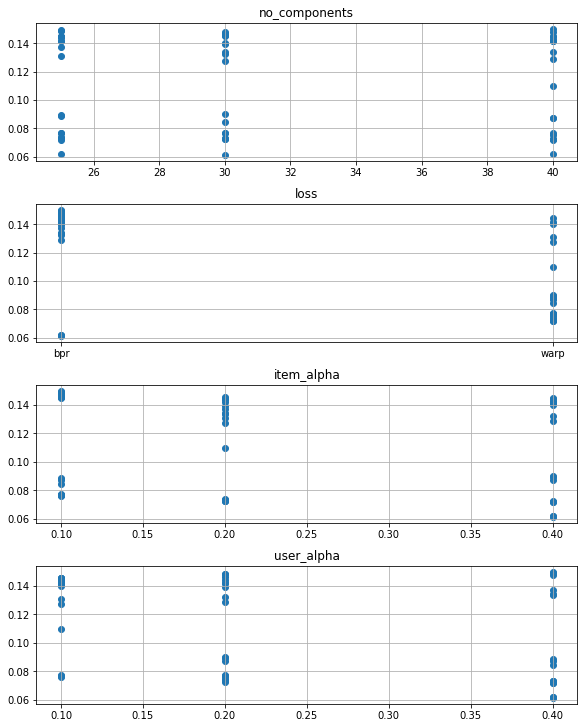

In [135]:
import numpy as np
import matplotlib.pyplot as plt

x1 = [params[i][0] for i in range(len(params))]
x2 = [params[i][1] for i in range(len(params))]
x3 = [params[i][2] for i in range(len(params))]
x4 = [params[i][3] for i in range(len(params))]
y = [params[i][4] for i in range(len(params))]

# Create figure
fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=4, constrained_layout=True, figsize=(8, 10))

ax0.scatter(x1, y)
ax0.set(title='no_components')
ax0.grid()

ax1.scatter(x2, y)
ax1.set(title='loss')
ax1.grid()

ax2.scatter(x3, y)
ax2.set(title='item_alpha')
ax2.grid()

ax3.scatter(x4, y)
ax3.set(title='user_alpha')
ax3.grid()

plt.show()

#### **Выводы:**

Несмотря на то, что функция потерь **warp** должна была дать результаты выше по метрике, в данном случае лучше справилась функция **bpr**.
Четкой зависимости от количества компонент или коэфициента регуляризации не прослеживается.

In [136]:
# Подставим лучшие параметры
# no_components: 40 | loss: bpr | item_alpha: 0.1 | user_alpha: 0.4 | precision_at_5: 0.14998357963874986
 
 
model = LightFM(no_components=40,
                loss='bpr',
                learning_rate=0.01, 
                item_alpha=0.1,
                user_alpha=0.4,
                random_state=42,
                k=5,
                n=15,
                max_sampled=100)
            
model.fit((sparse_user_item > 0) * 1,  # user-item matrix из 0 и 1
           sample_weight=coo_matrix(user_item_matrix),
           user_features=csr_matrix(user_feat_lightfm.values).tocsr(), # делает модель гибридной
           item_features=csr_matrix(item_feat_lightfm.values).tocsr(), # делает модель гибридной
           epochs=20, 
           num_threads=20,
           verbose=False) 


predictions = model.predict(user_ids=users_ids_row,
                            item_ids=items_ids_row,
                            user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                            item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                            num_threads=10)

data_train_filtered['score_new'] = predictions

predict_result = data_train_filtered[['user_id','item_id','score_new']][data_train_filtered.item_id != 999999].drop_duplicates().sort_values(by=['user_id','score_new'], ascending=False).groupby('user_id')['item_id']. \
  unique().reset_index()

df_result_for_metrics = result.merge(predict_result, on='user_id', how='inner')


precision = df_result_for_metrics.apply(lambda row: custom_precision(row['item_id'], row['actual'],k=5), axis=1).mean()

In [137]:
print(precision)

0.14988505747126232
